In [2]:
%matplotlib widget
from ipywidgets import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider
import control as ct

#### Constants
# Measured from the arduino
dt_micros = 300  # microseconds per loop
dt = dt_micros / 10**6  # seconds
t_start = 0  # seconds
t_end = 5.05  # seconds
num_points = int(np.ceil((t_end - t_start) / dt))
t_list = np.linspace(t_start, t_end, num_points)


M_BIG_MAGNET = 0.5920  # g
M_MED_MAGNET = 0.2307  # g
M_SMALL_MAGNET = 0.0521  # g
M_NUT = 1.3406  # g

NUM_BIG_MAGNET = 3
NUM_MED_MAGNET = 5
NUM_SMALL_MAGNET = 20
NUM_NUT = 3

MIN_DIST = 0.000001  # m
MAX_DIST = 0.15  # m

m = (
    M_BIG_MAGNET * NUM_BIG_MAGNET
    + M_MED_MAGNET * NUM_MED_MAGNET
    + M_SMALL_MAGNET * NUM_SMALL_MAGNET
    + M_NUT * NUM_NUT
) / 1000  # kg
R = 28.5  # Ohms
g = 9.8  # m/s^2
u_0 = 4 * np.pi * 10 ** (-7)
# TODO: Check this value
N = 1500  # number of turns
EM_DIAMETER = 0.034  # m
A = np.pi * (EM_DIAMETER / 2.0) ** 2  # m^2

pwm_setpoint = 200
v_0 = 200.0/255.0 * 12.0
i_0 = v_0/R  # amps
L = 0.051337  # H
K_E = (N*A)**2 * u_0 / 2.0
x_0 = i_0/np.sqrt(m*g/K_E)

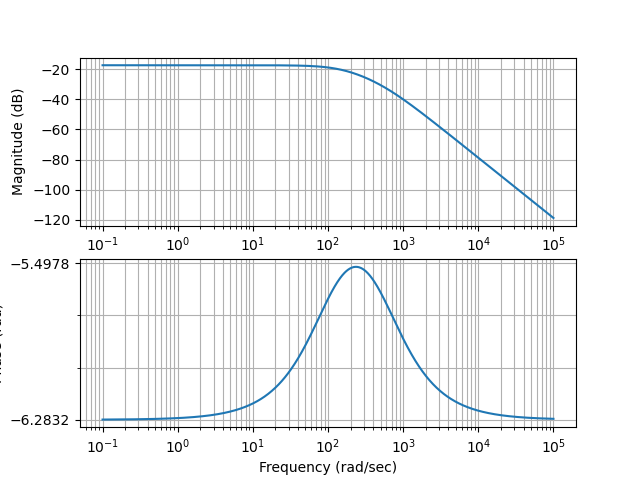

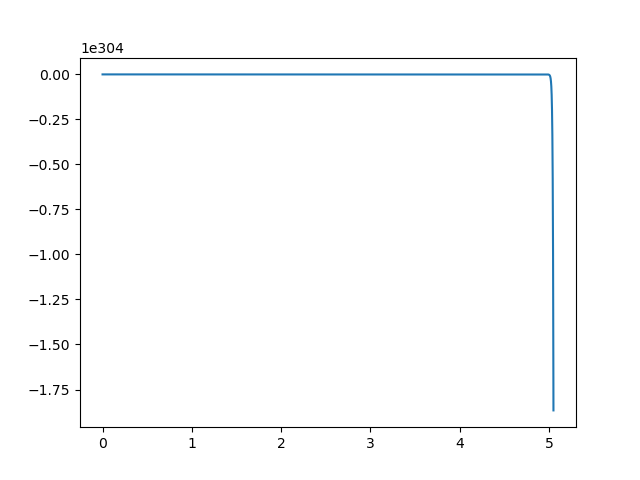

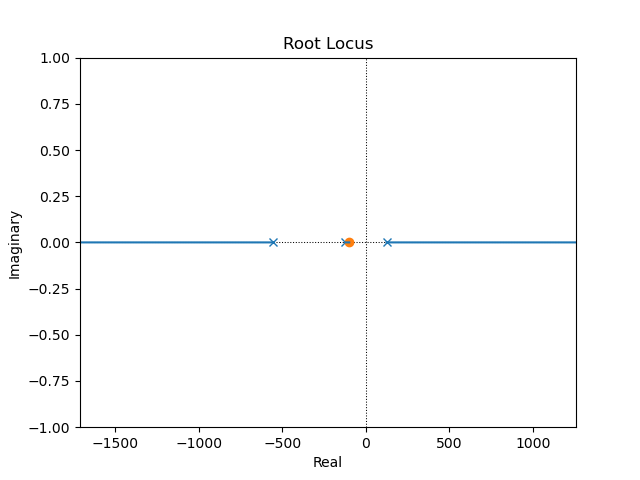

In [10]:
K_P = 1000.0
K_D = 10.0

G_1 = ct.tf([(-2.0*K_E*i_0)/(x_0**2)], [m, 0, (-2.0*K_E*i_0**2)/(x_0**3)])
G_2 = ct.tf([1], [L, R])
G = G_1*G_2
C = ct.tf([K_D, K_P], [1])
G_CL = C*G/(1+C*G)
plt.figure()
ct.root_locus(G*C, grid=False)
# ct.pzmap(G_CL)
plt.figure()
ct.bode_plot(G*C, dB=True, deg=False,omega_limits=(0.1, 100000))
plt.show()
plt.figure()
t_step, y_sys = ct.step_response(G_CL, T=t_list)
plt.plot(t_step, y_sys)
plt.show()

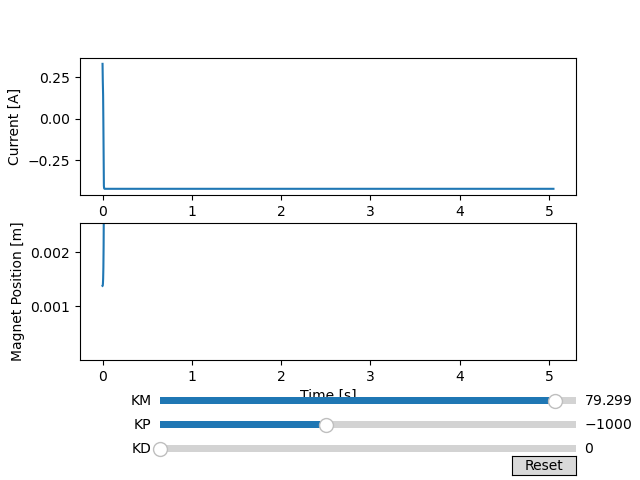

In [8]:
K_M = 79.299
def simulate(K_P, K_D):
    v = np.zeros(num_points)
    i = np.zeros(num_points)
    x = np.zeros(num_points)
    x[0] = x_0 + 0.0001
    x[1] = x_0 + 0.0001
    i[0] = i_0
    v[0] = v_0
    e_prev = 0

    for t in range(0, num_points - 2):
        e = x[t] - x_0
        disturbance = np.random.normal(0, 0.00001)
        v_i = np.clip(K_P * e + K_D * (e - e_prev) / dt + v_0, -12.0, 12.0)
        v[t + 1] = v_i
        i[t + 1] = i[t] + dt * (v_i - R * i[t]) / L
        x[t + 2] = np.clip(
            2 * x[t + 1] - x[t] + ((dt**2) / (m)) * ((x[t]*2*K_E*i_0**2)/(x_0**3) - (i[t]*i_0*2*K_E)/(x_0**2)),
            MIN_DIST,
            MAX_DIST,
        )
        # x[t + 2] = np.clip(
        #     2 * x[t + 1] - x[t] + ((dt**2) / (m)) * (m * g - (K_E * i[t] ** 2 + K_M*u_0) / x[t]),
        #     MIN_DIST,
        #     MAX_DIST,
        # )
    i[-1] = i[-2]
    return i, x


i, x = simulate(K_P,K_D)

fig, axs = plt.subplots(2)

(line_i,) = axs[0].plot(t_list, i, label="Current")
axs[0].set(xlabel="Time [s]", ylabel="Current [A]")

(line_x,) = axs[1].plot(t_list, x, label=f"Model")
axs[1].set(xlabel="Time [s]", ylabel="Magnet Position [m]")

fig.subplots_adjust(bottom=0.25)

axkm = fig.add_axes([0.25, 0.15, 0.65, 0.03])
km_slider = Slider(
    ax=axkm,
    label="KM",
    valmin=79.28,
    valmax=79.3,
    valinit=K_M,
)
axkp = fig.add_axes([0.25, 0.1, 0.65, 0.03])
kp_slider = Slider(
    ax=axkp,
    label="KP",
    valmin=-5000,
    valmax=5000,
    valinit=K_P,
    valstep=100,
)
axkd = fig.add_axes([0.25, 0.05, 0.65, 0.03])
kd_slider = Slider(
    ax=axkd,
    label="KD",
    valmin=0,
    valmax=30,
    valinit=K_D,
    valstep=0.5,
)


def update(val):
    i, x = simulate(kp_slider.val, kd_slider.val, km_slider.val)
    line_i.set_ydata(i)
    line_x.set_ydata(x)
    fig.canvas.draw_idle()


axs[1].set_ylim(MIN_DIST, x_0 * 2)
km_slider.on_changed(update)
kp_slider.on_changed(update)
kd_slider.on_changed(update)
resetax = fig.add_axes([0.8, 0.01, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    kp_slider.set_val(K_P)
    kd_slider.set_val(K_D)
button.on_clicked(reset)
# plt.tight_layout()
plt.show()